This notebook will be used with the aim of showing how a logistic regression works:

# 1. Set up

# 2. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

import category_encoders as ce

In [2]:
import warnings

warnings.simplefilter("ignore")

# 3. Define global variables

In [3]:
INPUT_DATA = "../../data/credit_card_data/Credit_card.csv"
INPUT_TARGET = "../../data/credit_card_data/Credit_card_label.csv"

# 4. Functions

# 5. Code

We are going to make use of some credit card details data. The data is taken from https://www.kaggle.com/datasets/rohitudageri/credit-card-details.

Variables:

- Ind_ID: Client ID
- Gender: Gender information
- Car_owner: Having car or not
- Propert_owner: Having property or not
- Children: Count of children
- Annual_income: Annual income
- Type_Income: Income type
- Education: Education level
- Marital_status: Marital_status
- Housing_type: Living style
- Birthday_count: Use backward count from current day (0), -1 means yesterday.
- Employed_days: Start date of employment. Use backward count from current day (0). Positive value means, individual is currently unemployed.
- Mobile_phone: Any mobile phone
- Work_phone: Any work phone
- Phone: Any phone number
- EMAIL_ID: Any email ID
- Type_Occupation: Occupation
- Family_Members: Family size
- Label: 0 is application approved and 1 is application rejected.

## 5.1. Load and transform data

First of all we are going to load the both the data and the target variables making use of pandas library

In [4]:
data = pd.read_csv(INPUT_DATA)
data.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


In [5]:
target = pd.read_csv(INPUT_TARGET).rename(columns={"label": "target"})
target.head()

,Ind_ID,target
0,5008827,1
1,5009744,1
2,5009746,1
3,5009749,1
4,5009752,1


Let's join both data frames in order to have the complete dataset:

In [6]:
input_df = data.merge(target, on=["Ind_ID"], how="inner")

input_df.head()

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,target
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1


First of all let's modify column names, lowercase always

In [7]:
input_df.rename(columns=str.lower, inplace=True)

Now, we are going to delete the id, we are not using it:

In [8]:
input_df.drop("ind_id", axis=1, inplace=True)

Let's do a little EDA in order to understand the data and to determine wether if we can use all the information or not.

### Duplicated data?

In [9]:
input_df.duplicated().sum()

162

In [10]:
input_df.drop_duplicates(inplace=True)

### Null values?

In [11]:
input_df.isnull().mean() * 100

gender              0.505051
car_owner           0.000000
propert_owner       0.000000
children            0.000000
annual_income       1.659452
type_income         0.000000
education           0.000000
marital_status      0.000000
housing_type        0.000000
birthday_count      1.587302
employed_days       0.000000
mobile_phone        0.000000
work_phone          0.000000
phone               0.000000
email_id            0.000000
type_occupation    31.601732
family_members      0.000000
target              0.000000
dtype: float64

Watching this, as our aim is to see the functioning of the logistic regression, we are going to delete the variables where we have some null values although this shouldn't be done but we are just focusing on logistic regression functioning

In [12]:
input_df.drop(["type_occupation", "gender", "birthday_count", "annual_income"], axis=1, inplace=True)

In [13]:
input_df.head(5)

,car_owner,propert_owner,children,type_income,education,marital_status,housing_type,employed_days,mobile_phone,work_phone,phone,email_id,family_members,target
0,Y,Y,0,Pensioner,Higher education,Married,House / apartment,365243,1,0,0,0,2,1
1,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
2,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
3,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
5,Y,N,0,Pensioner,Higher education,Married,House / apartment,-586,1,1,1,0,2,1


### Imbalance dataset?

In [14]:
input_df["target"].value_counts(normalize=True)

0    0.901154
1    0.098846
Name: target, dtype: float64

Yes, but not that much

### Train / test split

Before doing transformations in the data, we need to divide it into train and test. **Let's remember that all transformations must be fitted in the training dataset**

In [15]:
X = input_df.drop("target", axis=1)
y = input_df["target"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
y_train.value_counts(normalize=True)

0    0.894845
1    0.105155
Name: target, dtype: float64

In [18]:
y_test.value_counts(normalize=True)

0    0.915865
1    0.084135
Name: target, dtype: float64

We need to transform all categorical columns to numeric. First, let's detect them:

In [19]:
categorical_cols = input_df.select_dtypes(include="object").columns

We are going to use target encoder in order to transform the categorical data:

In [20]:
target_encoder = ce.TargetEncoder(cols = categorical_cols)

In [21]:
X_train_processed = target_encoder.fit_transform(X_train, y_train)
X_test_processed = target_encoder.transform(X_test)

Would it be correct to run a logistic regression with this data? NO

The data must be standarized in order to compare coeffiecients when the logistic regression is calculated

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

## 5.2. Training

Let's initialize the model and train it then:

In [23]:
model = LogisticRegression(random_state=42)

model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

Once the model is trained, let's calculate predictions of the X_test_scaled data:

In [24]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

## 5.3. Metrics calculation

First, let's calculate some metrics and show them:

In [25]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [26]:
print(f"The accuracy error value is: {accuracy}")
print(f"The roc_auc value is: {roc_auc}")

The accuracy error value is: 0.9134615384615384
The roc_auc value is: 0.6119610048743906


Now we will plot both the confusion matrix and the roc curve:

**Confusion matrix:**

In [27]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")

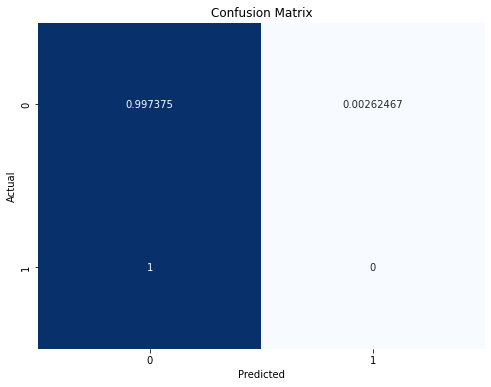

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can observe a very bad result for the confusion matrix. This is because of the threshold considered when calculating y_pred. We need to modify this threshold. We are considering the value 0.1 because is the default imbalance value:

In [29]:
y_pred_new = np.where(y_pred_proba >= 0.1, 1, 0)

In [30]:
accuracy = accuracy_score(y_test, y_pred_new)
print(f"The accuracy error value is: {accuracy}")

The accuracy error value is: 0.6322115384615384


In [31]:
conf_matrix = confusion_matrix(y_test, y_pred_new, normalize="true")

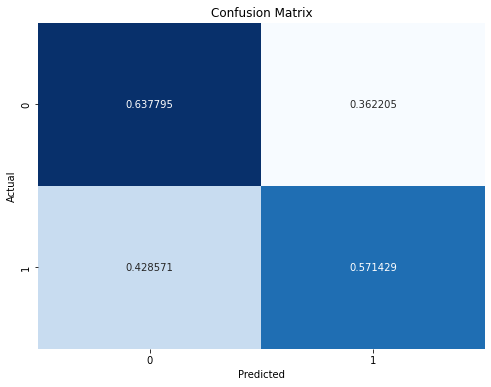

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can observe a better performance of the model now. However, let's remember that this is for logistic regression understanding purposes only. If we would like to find the best model, we should have to be more cautious and more precise when selecting the threshold

**ROC Curve:**

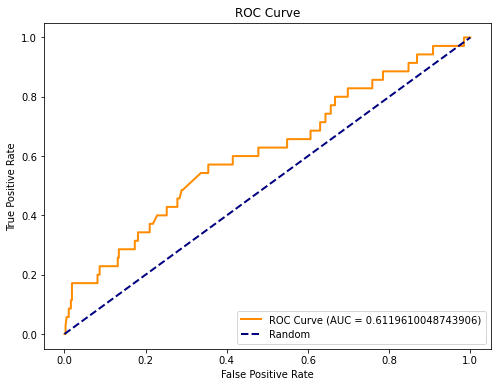

In [33]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## 5.4. Interpretation